In [278]:
import matplotlib.pyplot as plt
import IPython.display as ipd

import librosa
from librosa.util import find_files
from librosa import load

import os
import numpy as np

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import Huber
from tensorflow.keras.models import load_model


from tensorflow import keras
from keras import Model
from keras.models import Sequential
from keras.layers import  Dense, LSTM

from pesq import pesq
import soundfile as sf
from pystoi import stoi

from utils import *

In [ ]:
SR =  8000
window_size = 1024
hop_length= 208
window='hann'

### Dataset creation

In [276]:
noise , _ = librosa.load('babble.wav',sr=None)
noising_all("clean/train", "noisy/train",noise,sr=8000)
noising_all("clean/test", "clean/test",noise,sr=8000)

Done noising and writing noisy audios to "noisy/train
Done noising and writing noisy audios to "noisy/test


#### Example of a noised audio

audio non bruité Fs = 8000, Duration = 10.00 seconds, x.shape = (80000,), x.dtype = float32


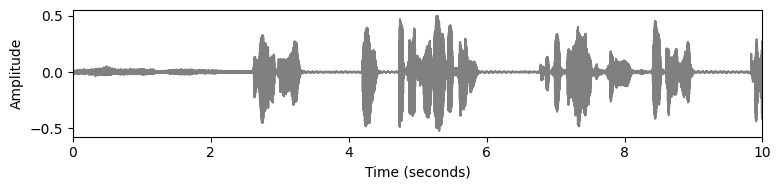

audio bruité Fs = 8000, Duration = 10.00 seconds, x.shape = (80000,), x.dtype = float32


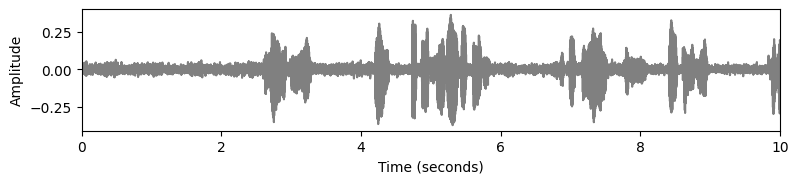

SNR entre les signaux propres et bruités : 8.66 dB


In [3]:
audio, sr = librosa.load('clean/train_small/Jules_Verne_-_L_ile_mysterieuse_Partie1_Chap01_2_.wav', sr =None)
print_plot_play(audio, sr, text='audio non bruité')
audio1, sr1 = librosa.load('noisy/train_small/Jules_Verne_-_L_ile_mysterieuse_Partie1_Chap01_2_.wav', sr=None)
print_plot_play(audio1, sr1, text='audio bruité')
snr_value = calculate_snr(audio, audio1)
print(f"SNR entre les signaux propres et bruités : {snr_value:.2f} dB")


All audios (noisy and clean) are of length 10s and sampled at a rate 8Khz

 To compute STFT, win_length = 1024 is choosen, this is equivalent to a time resolution of approximately 125ms.
 setting n_fft to a power of two  optimizes the speed of the fast Fourier transform (FFT) algorithm.
 Smaller values increase the number of columns in D without affecting the frequency resolution of the STFT.

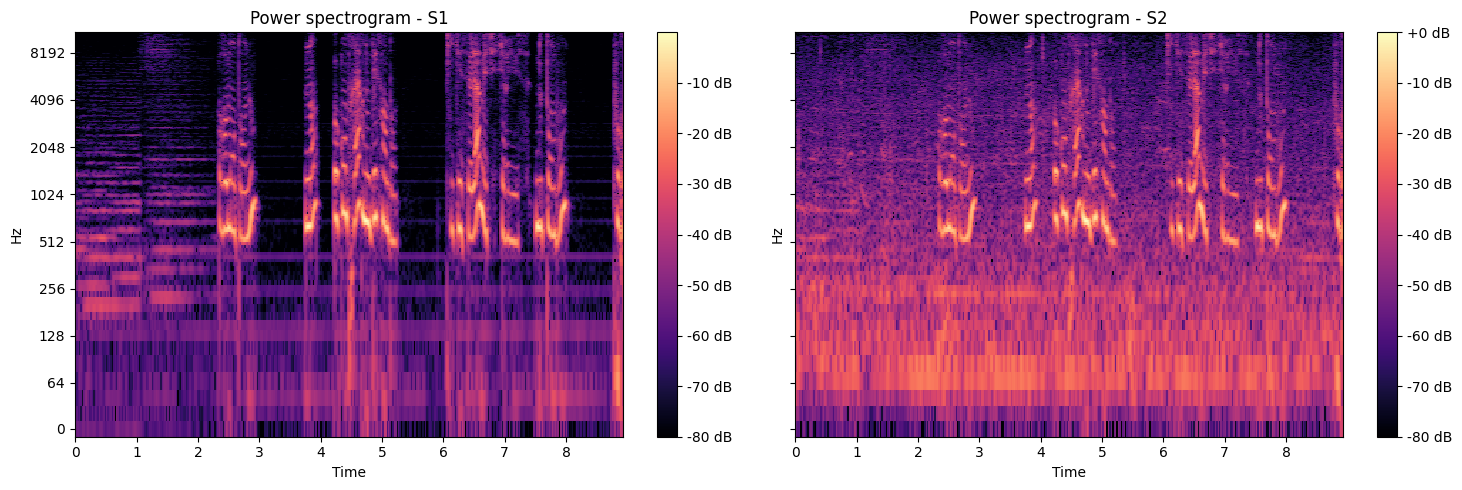

In [11]:
spectrogramme_display(audio, audio1)


The most fundamental properties of a speech signal are its formants and harmonic structure. Formants correspond to the macro-level shape on the frequency axis, while the harmonic structure is the micro-level structure. That is, if we extra macro-level shape, the frequency-envelope, and remove its effect, we obtain the harmonic structure.

In the following code, we compute spectrograms of both noisy and clean audios and save them in a folder

In [22]:
noisy_path = './noisy/train'
clean_path = './clean/train'
terminal_path = '/train'
create_spectrograms(noisy_path , clean_path,terminal_path)

Success


In [12]:
noisy_path = './noisy/test'
clean_path = './clean/test'
terminal_path = '/test'
create_spectrograms(noisy_path  , clean_path,terminal_path)

Success


# TRAIN 

### U-NET

In [183]:
#Load the data
X_list, Y_list = LoadSpectrogram('/train')
X_mag,_ = Magnitude_phase(X_list)
Y_mag,_ = Magnitude_phase(Y_list)
np.shape(X_mag)

(2118, 513, 385)

In [176]:
X = np.array(X_mag)
Y = np.array(Y_mag)
X = X[:, 1:, 1:, np.newaxis]
Y = Y[:, 1:, 1:, np.newaxis]

In [177]:
def U_Net(input_shape):
    # Input Layer
    input_layer = tf.keras.Input(shape=input_shape)

    # Convolutional Layer 1
    conv1 = tf.keras.layers.BatchNormalization()(tf.keras.layers.Conv2D(filters=16, kernel_size=[5,5],
                                                                       strides=[2,2], padding="same", activation=tf.nn.leaky_relu)(input_layer))

    # Convolutional Layer 2
    conv2 = tf.keras.layers.BatchNormalization()(tf.keras.layers.Conv2D(filters=32, kernel_size=[5,5],
                                                                       strides=[2,2], padding="same", activation=tf.nn.leaky_relu)(conv1))

    # Convolutional Layer 3
    conv3 = tf.keras.layers.BatchNormalization()(tf.keras.layers.Conv2D(filters=64, kernel_size=[5,5],
                                                                       strides=[2,2], padding="same", activation=tf.nn.leaky_relu)(conv2))

    # Convolutional Layer 4
    conv4 = tf.keras.layers.BatchNormalization()(tf.keras.layers.Conv2D(filters=128, kernel_size=[5,5],
                                                                       strides=[2,2], padding="same", activation=tf.nn.leaky_relu)(conv3))

    # Convolutional Layer 5
    conv5 = tf.keras.layers.BatchNormalization()(tf.keras.layers.Conv2D(filters=256, kernel_size=[5,5],
                                                                       strides=[2,2], padding="same", activation=tf.nn.leaky_relu)(conv4))

    # Deconvolutional Layer1 (dropout)
    deconv2 = tf.keras.layers.BatchNormalization()(tf.keras.layers.Conv2DTranspose(filters=128, kernel_size=[5,5],
                                                                                   strides=[2,2], padding="same",
                                                                                     activation=tf.nn.relu)
                                                                                     (conv5))
    dropout2 = tf.keras.layers.Dropout(rate=0.5)(deconv2)


    # Deconvolutional Layer2 (dropout)
    deconv3 = tf.keras.layers.BatchNormalization()(tf.keras.layers.Conv2DTranspose(filters=64, kernel_size=[5,5],
                                                                                   strides=[2,2], padding="same",
                                                                                     activation=tf.nn.relu)
                                                                                     (tf.concat([dropout2, conv4], 3)))
    dropout3 = tf.keras.layers.Dropout(rate=0.5)(deconv3)

    # Deconvolutional Layer3
    deconv4 = tf.keras.layers.BatchNormalization()(tf.keras.layers.Conv2DTranspose(filters=32, kernel_size=[5,5],
                                                                                   strides=[2,2], padding="same", activation=tf.nn.relu)(tf.concat([dropout3, conv3], 3)))

    # Deconvolutional Layer4
    deconv5 = tf.keras.layers.BatchNormalization()(tf.keras.layers.Conv2DTranspose(filters=16, kernel_size=[5,5],
                                                                                   strides=[2,2], padding="same", activation=tf.nn.relu)(tf.concat([deconv4, conv2], 3)))

    # Deconvolutional Layer5
    deconv6 = tf.keras.layers.Conv2DTranspose(filters=1, kernel_size=[5, 5], strides=[2, 2], padding="same", activation=tf.nn.relu)(tf.concat([deconv5, conv1],3))

    # Convert labels to a tensor if it's not already
    #predictions = {'outputs': deconv6}

    model = models.Model(inputs=input_layer, outputs=deconv6)
    return model

In [179]:
input_shape=(512, 384, 1)
model = U_Net(input_shape=input_shape)
custom_optimizer = Adam(learning_rate=0.02)
huber_loss = Huber(delta=1)
model.compile(optimizer=custom_optimizer, loss=huber_loss)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 512, 384, 1)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 256, 192, 16)         416       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 256, 192, 16)         64        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 conv2d_1 (Conv2D)           (None, 128, 96, 32)          12832     ['batch_normalization[0][0

In [211]:
history = model.fit(
    X,  # Input data
    Y,             
    epochs=100,     
    batch_size=50,  
    validation_split=0.2,  
)

Epoch 1/100
34/34 [==============================] - 470s 7s/step - loss: 0.0594 - val_loss: 0.1973
Epoch 2/100
34/34 [==============================] - 470s 7s/step - loss: 0.0364 - val_loss: 0.1421
Epoch 3/100
34/34 [==============================] - 470s 7s/step - loss: 0.0357 - val_loss: 0.1304
Epoch 4/100
34/34 [==============================] - 470s 7s/step - loss: 0.0341 - val_loss: 0.1044
Epoch 5/100
34/34 [==============================] - 470s 7s/step - loss: 0.0331 - val_loss: 0.0823
Epoch 6/100
34/34 [==============================] - 470s 7s/step - loss: 0.0328 - val_loss: 0.0797
Epoch 7/100
34/34 [==============================] - 470s 7s/step - loss: 0.0319 - val_loss: 0.0756
Epoch 8/100
34/34 [==============================] - 470s 7s/step - loss: 0.0323 - val_loss: 0.0824
Epoch 9/100
34/34 [==============================] - 470s 7s/step - loss: 0.0325 - val_loss: 0.0629
Epoch 10/100
34/34 [==============================] - 470s 7s/step - loss: 0.0303 - val_loss: 0.0710

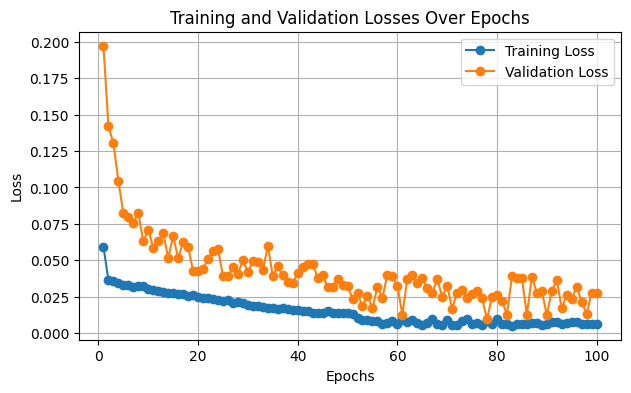

In [215]:
plt.plot(history.history['loss'], label='Training Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [182]:
model.save('unet_100epoch.h5')

### Evaluate U-Net

In [266]:
model_path = "unet_100epoch.h5"
model = load_model(model_path)

In [268]:
write_files(model,'noisy/test', 'predict/test2')

1/1 [==============================] - 0s 62ms/step
Done writing to predict/test2


In [269]:
pesq_scores_before,stoi_scores_before, snr_scores_before = evaluate_model('clean/test', 'noisy/test')
pesq_scores_after,stoi_scores_ater, snr_scores_after = evaluate_model('clean/test', 'predict/test2')

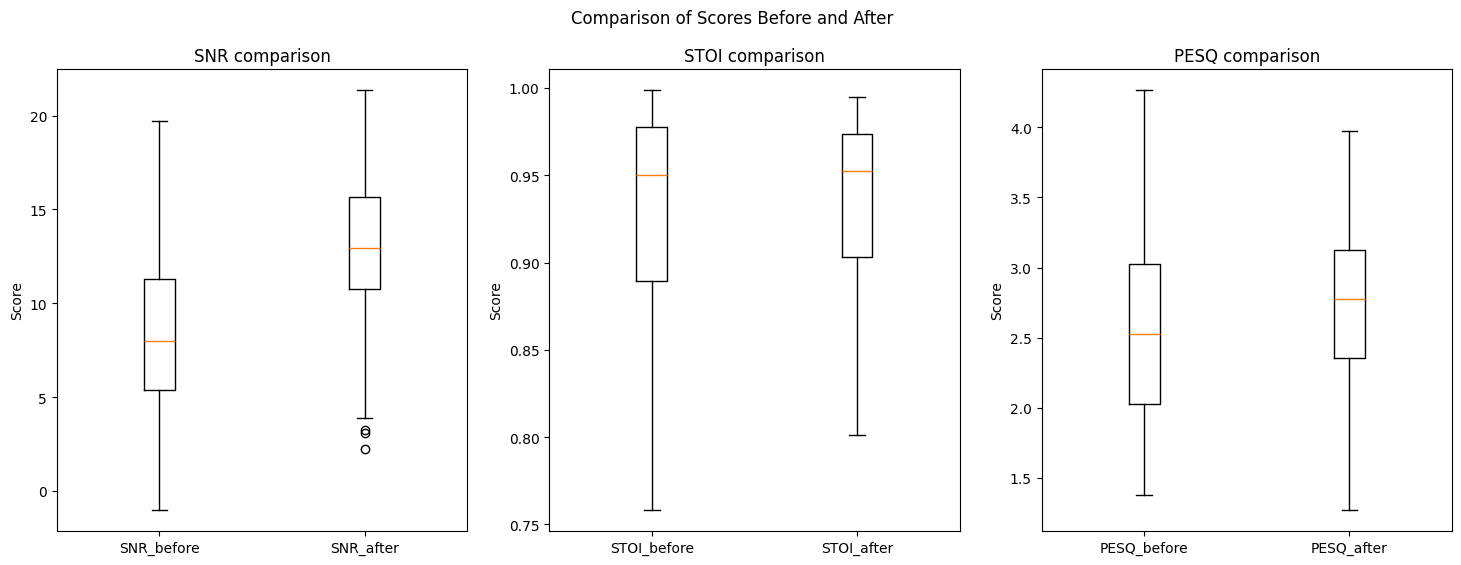

In [270]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
axes[0].boxplot([snr_scores_before, snr_scores_after], labels=['SNR_before', 'SNR_after'])
axes[0].set_title('SNR comparison')

# STOI comparison
axes[1].boxplot([stoi_scores_before, stoi_scores_ater], labels=['STOI_before', 'STOI_after'],showfliers =False)
axes[1].set_title('STOI comparison')

# PESQ comparison
axes[2].boxplot([pesq_scores_before, pesq_scores_after], labels=['PESQ_before', 'PESQ_after'])
axes[2].set_title('PESQ comparison')

for ax in axes:
    ax.set_ylabel('Score')
plt.suptitle('Comparison of Scores Before and After')
plt.show()

#### Example of denoising

audio non bruité Fs = 8000, Duration = 10.00 seconds, x.shape = (80000,), x.dtype = float32


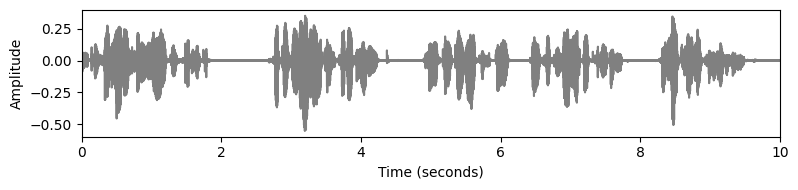

audio bruité Fs = 8000, Duration = 10.00 seconds, x.shape = (80000,), x.dtype = float32


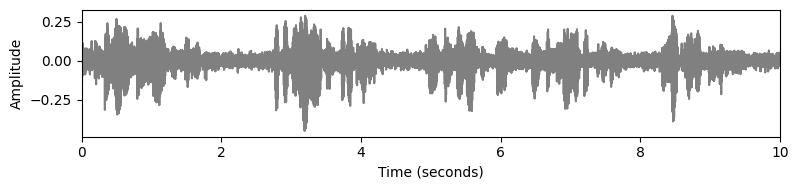

SNR entre les signaux propres et bruités : 7.42 dB
audio bruité Fs = 8000, Duration = 9.98 seconds, x.shape = (79872,), x.dtype = float32


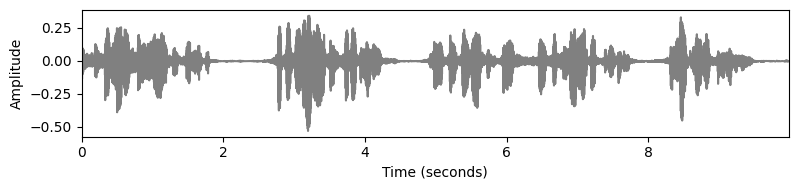

SNR entre les signaux propres et prédit : 13.10 dB


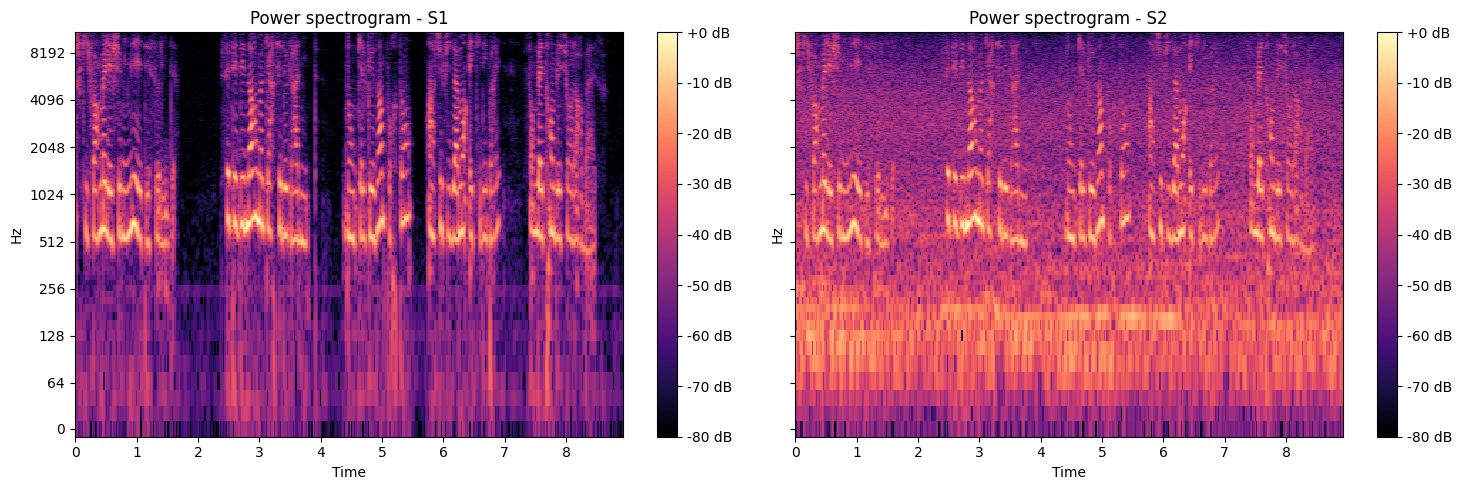

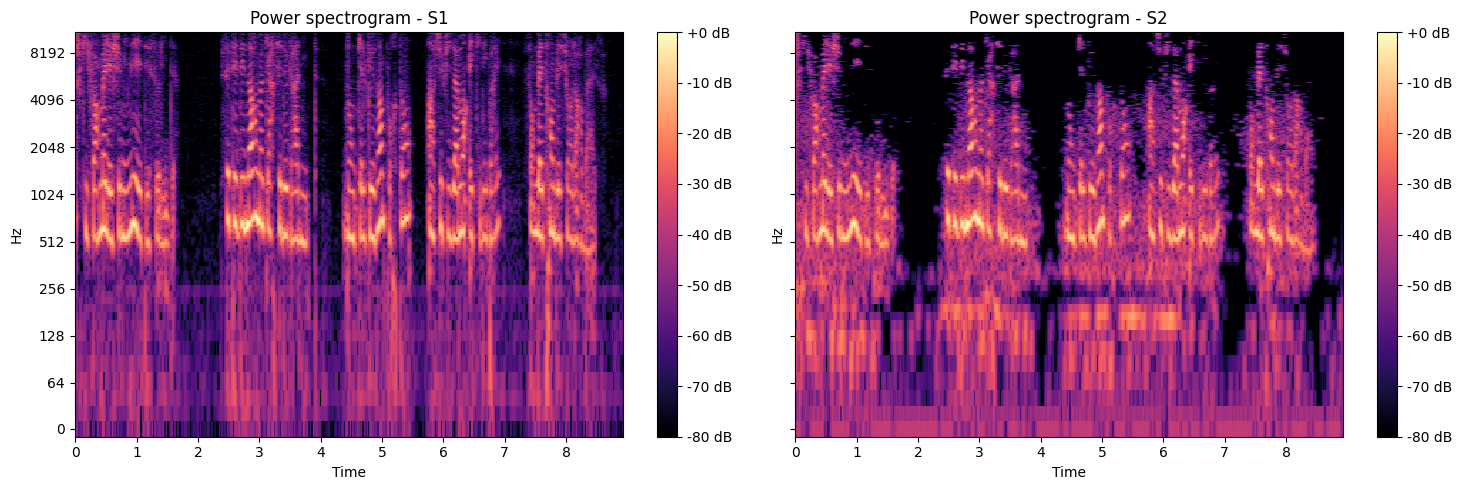

In [226]:
i = 49
audio, sr = librosa.load(f'clean/test/Jules_Verne_-_L_ile_mysterieuse_Partie1_Chap07_{i}_.wav', sr =None)
print_plot_play(audio, sr, text='audio non bruité')
audio1, sr1 = librosa.load(f'noisy/test/Jules_Verne_-_L_ile_mysterieuse_Partie1_Chap07_{i}_.wav', sr=None)
print_plot_play(audio1, sr1, text='audio bruité')
snr_value = calculate_snr(audio, audio1)
print(f"SNR entre les signaux propres et bruités : {snr_value:.2f} dB")

audio2, sr2 = librosa.load(f'predict/test/Jules_Verne_-_L_ile_mysterieuse_Partie1_Chap07_{i}_.wav', sr=None)
print_plot_play(audio2, sr2, text='audio bruité')
snr_value2 = calculate_snr(audio, audio2)
print(f"SNR entre les signaux propres et prédit : {snr_value2:.2f} dB")

spectrogramme_display(audio, audio1)
spectrogramme_display(audio, audio2)

# LSTM

In [162]:
lstm_out = 513
time_step= 30

In [275]:
#reshape the data for the entry of lstm
X_concat = np.concatenate(np.array(X_mag), axis=1)
Y_concat = np.concatenate(np.array(Y_mag), axis=1)
X_train = X_concat.T
y_train = Y_concat.T
shape_train =(np.shape(X_train)[0])//time_step
max_train = shape_train * time_step
X3d_train = X_train[:max_train,:]
X3d_train = np.reshape(X3d_train, (shape_train,time_step,513))
Y3d_train = y_train[:max_train,:]
Y3d_train = np.reshape(Y3d_train,(shape_train,time_step,513))

In [165]:
print(np.shape(X3d_train))

(27181, 30, 513)


In [171]:
#define the model

model_lstm = Sequential()
model_lstm.add(Dense(513,activation='ReLU'))
model_lstm.add(LSTM(lstm_out, dropout = 0.01, return_sequences=True ,input_shape=(time_step,513)))
model_lstm.add(LSTM(lstm_out, dropout = 0.1, return_sequences=True ,input_shape=(time_step,513)))
model_lstm.add(Dense(513,activation='ReLU'))
model_lstm.add(Dense(513,activation='ReLU'))

optimiser = keras.optimizers.Adam(learning_rate=0.01)
model_lstm.compile(optimizer = 'adam', loss=huber_loss)

In [172]:
history_lstm = model_lstm.fit(X3d_train , Y3d_train , validation_split = 0.2,batch_size=100,epochs=50)

Epoch 1/50
218/218 [==============================] - 448s 2s/step - loss: 0.0677 - val_loss: 0.0724
Epoch 2/50
218/218 [==============================] - 337s 2s/step - loss: 0.0423 - val_loss: 0.0544
Epoch 3/50
218/218 [==============================] - 329s 2s/step - loss: 0.0371 - val_loss: 0.0500
Epoch 4/50
218/218 [==============================] - 338s 2s/step - loss: 0.0348 - val_loss: 0.0465
Epoch 5/50
218/218 [==============================] - 336s 2s/step - loss: 0.0331 - val_loss: 0.0461
Epoch 6/50
218/218 [==============================] - 331s 2s/step - loss: 0.0316 - val_loss: 0.0553
Epoch 7/50
218/218 [==============================] - 281s 1s/step - loss: 0.0306 - val_loss: 0.0471
Epoch 8/50
218/218 [==============================] - 252s 1s/step - loss: 0.0296 - val_loss: 0.0474
Epoch 9/50
218/218 [==============================] - 198s 908ms/step - loss: 0.0286 - val_loss: 0.0457
Epoch 10/50
218/218 [==============================] - 208s 955ms/step - loss: 0.0276 - 

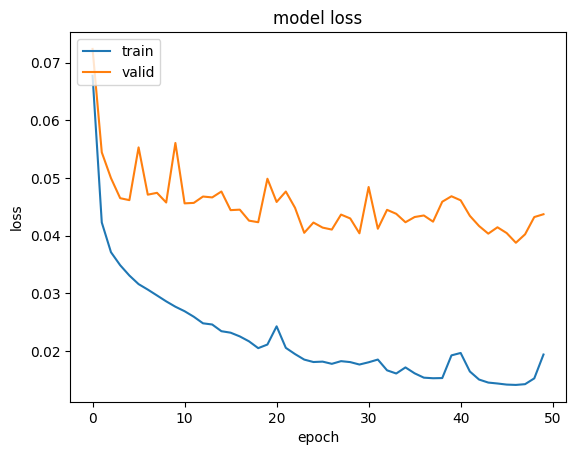

In [173]:

plt.plot(history_lstm.history['loss'])
plt.plot(history_lstm.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')


In [174]:
model_lstm.save('model_lstm2.h5')

c:\Users\User\anaconda3new\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


### Evaluate LSTM

In [233]:
model_path = "model_lstm2.h5"
model_lstm= load_model(model_path)

In [257]:
write_files(model_lstm,'noisy/test', 'predict/test_lstm',lstm=True)

1/1 [==============================] - 0s 79ms/step
(513, 360)
1/1 [==============================] - 0s 62ms/step
(513, 360)
1/1 [==============================] - 0s 62ms/step
(513, 360)
1/1 [==============================] - 0s 78ms/step
(513, 360)
1/1 [==============================] - 0s 62ms/step
(513, 360)
1/1 [==============================] - 0s 63ms/step
(513, 360)
1/1 [==============================] - 0s 85ms/step
(513, 360)
1/1 [==============================] - 0s 86ms/step
(513, 360)
1/1 [==============================] - 0s 102ms/step
(513, 360)
1/1 [==============================] - 0s 67ms/step
(513, 360)
1/1 [==============================] - 0s 60ms/step
(513, 360)
1/1 [==============================] - 0s 84ms/step
(513, 360)
1/1 [==============================] - 0s 68ms/step
(513, 360)
1/1 [==============================] - 0s 67ms/step
(513, 360)
1/1 [==============================] - 0s 66ms/step
(513, 360)
1/1 [==============================] - 0s 62ms/step
(5

In [260]:
pesq_scores_before,stoi_scores_before, snr_scores_before = evaluate_model('clean/test', 'noisy/test')
pesq_scores_after,stoi_scores_ater, snr_scores_after = evaluate_model('clean/test', 'predict/test_lstm')

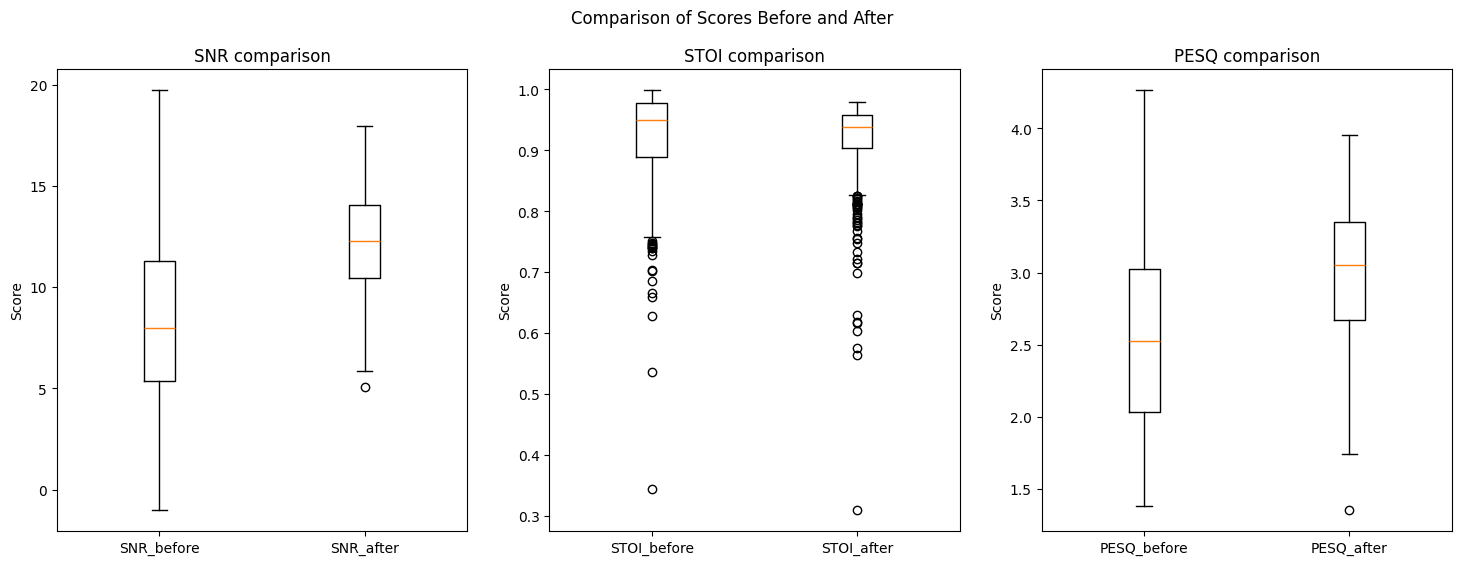

In [264]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
# SNR comparison
axes[0].boxplot([snr_scores_before, snr_scores_after], labels=['SNR_before', 'SNR_after'])
axes[0].set_title('SNR comparison')

# STOI comparison
axes[1].boxplot([stoi_scores_before, stoi_scores_ater], labels=['STOI_before', 'STOI_after'],showfliers =False)
axes[1].set_title('STOI comparison')

# PESQ comparison
axes[2].boxplot([pesq_scores_before, pesq_scores_after], labels=['PESQ_before', 'PESQ_after'])
axes[2].set_title('PESQ comparison')

for ax in axes:
    ax.set_ylabel('Score')

plt.suptitle('Comparison of Scores Before and After')
plt.show()


audio non bruité Fs = 8000, Duration = 10.00 seconds, x.shape = (80000,), x.dtype = float32


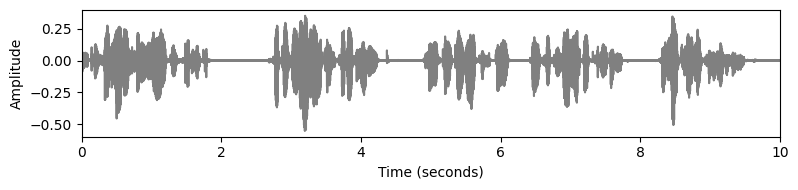

audio bruité Fs = 8000, Duration = 10.00 seconds, x.shape = (80000,), x.dtype = float32


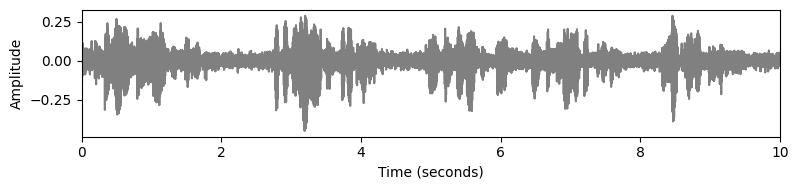

SNR entre les signaux propres et bruités : 7.42 dB
audio bruité Fs = 8000, Duration = 9.33 seconds, x.shape = (74672,), x.dtype = float32


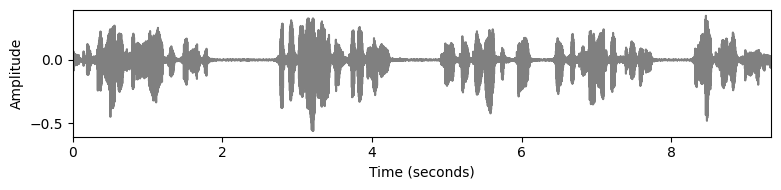

SNR entre les signaux propres et prédit : 15.05 dB


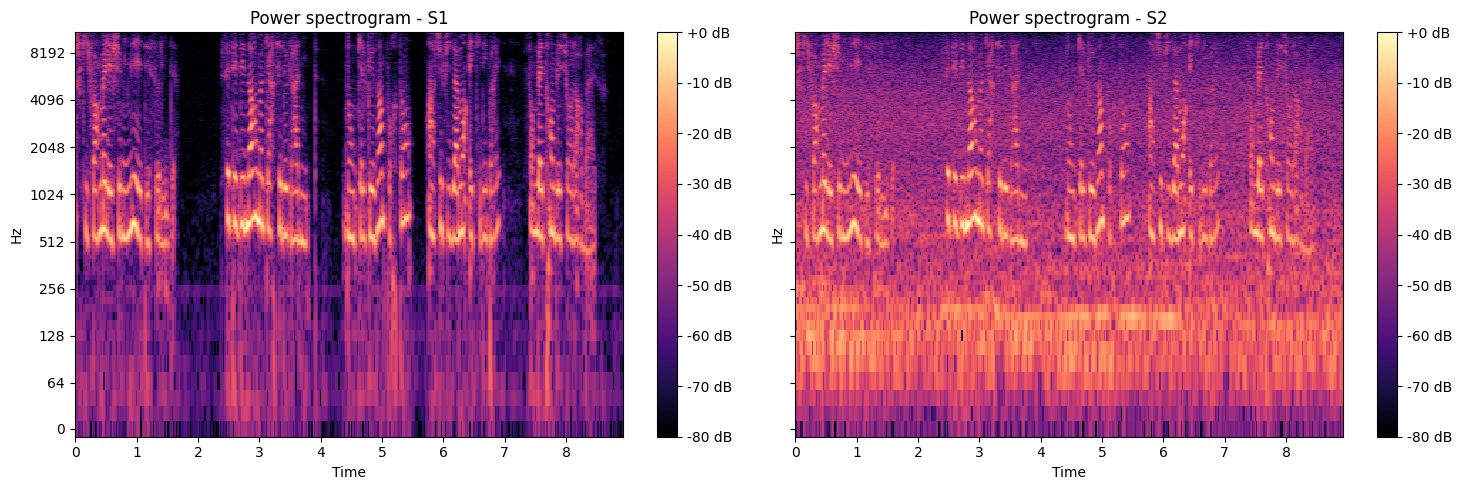

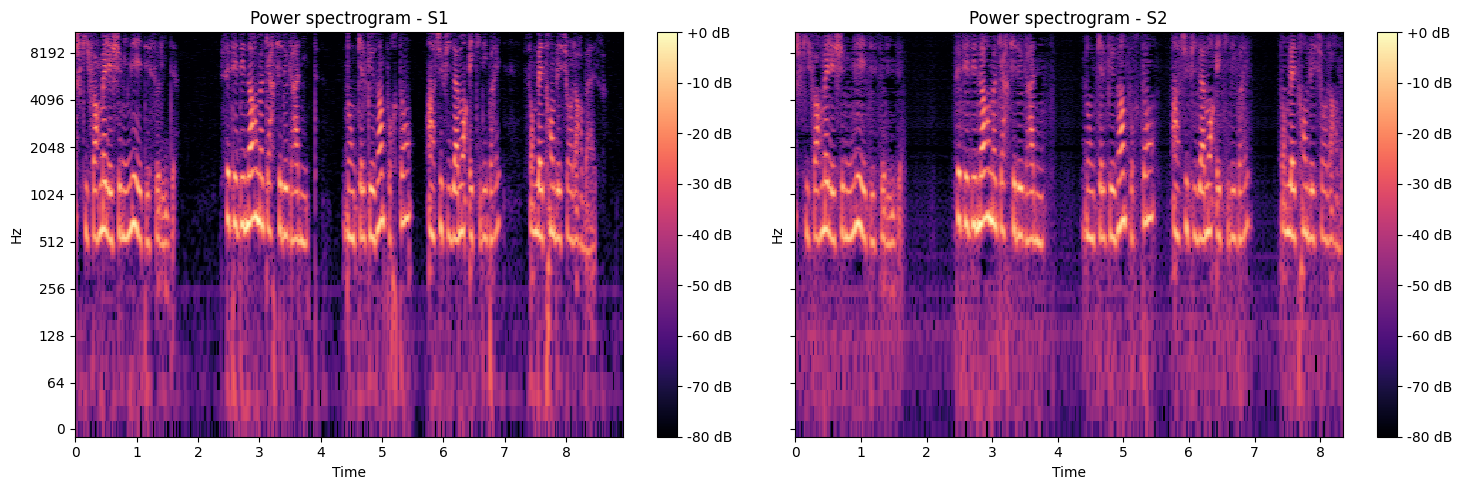

In [265]:
i = 49
audio, sr = librosa.load(f'clean/test/Jules_Verne_-_L_ile_mysterieuse_Partie1_Chap07_{i}_.wav', sr =None)
print_plot_play(audio, sr, text='audio non bruité')
audio1, sr1 = librosa.load(f'noisy/test/Jules_Verne_-_L_ile_mysterieuse_Partie1_Chap07_{i}_.wav', sr=None)
print_plot_play(audio1, sr1, text='audio bruité')
snr_value = calculate_snr(audio, audio1)
print(f"SNR entre les signaux propres et bruités : {snr_value:.2f} dB")

audio2, sr2 = librosa.load(f'predict/test_lstm/Jules_Verne_-_L_ile_mysterieuse_Partie1_Chap07_{i}_.wav', sr=None)
print_plot_play(audio2, sr2, text='audio bruité')
snr_value2 = calculate_snr(audio, audio2)
print(f"SNR entre les signaux propres et prédit : {snr_value2:.2f} dB")

spectrogramme_display(audio, audio1)
spectrogramme_display(audio, audio2)

audio non bruité Fs = 8000, Duration = 10.00 seconds, x.shape = (80000,), x.dtype = float32


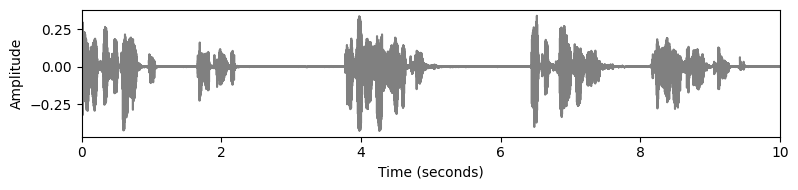

audio bruité Fs = 8000, Duration = 10.00 seconds, x.shape = (80000,), x.dtype = float32


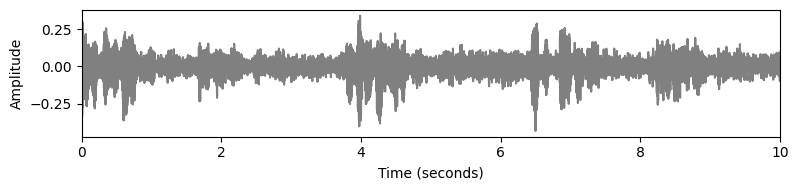

SNR entre les signaux propres et bruités : 2.21 dB
audio bruité Fs = 8000, Duration = 9.33 seconds, x.shape = (74672,), x.dtype = float32


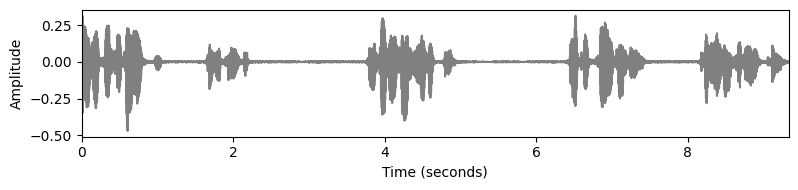

SNR entre les signaux propres et prédit : 12.62 dB


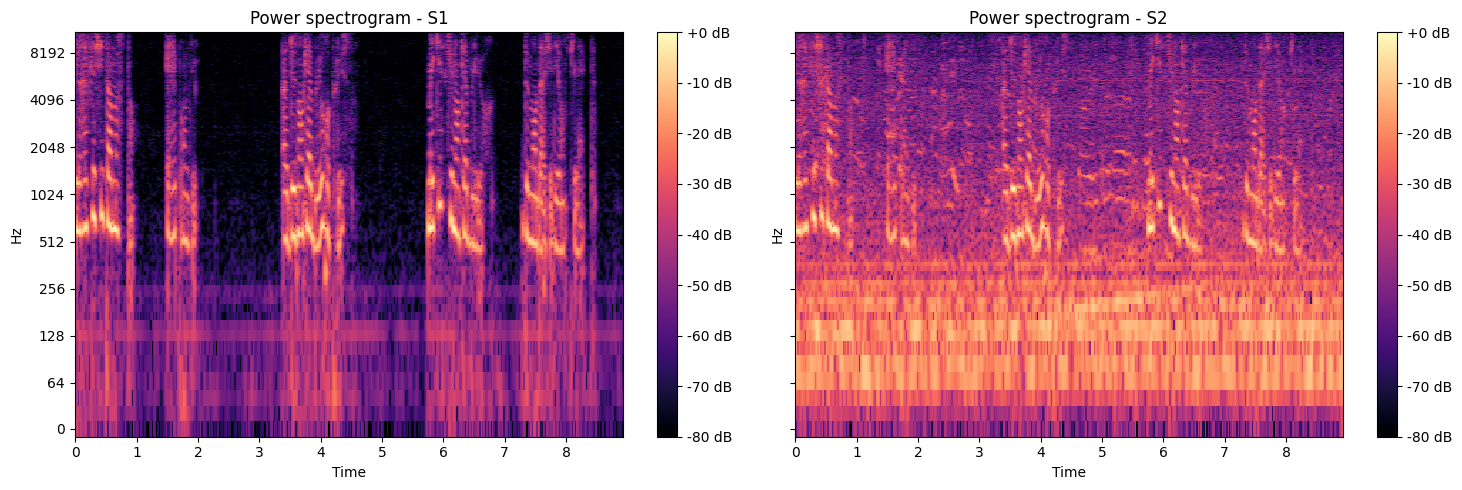

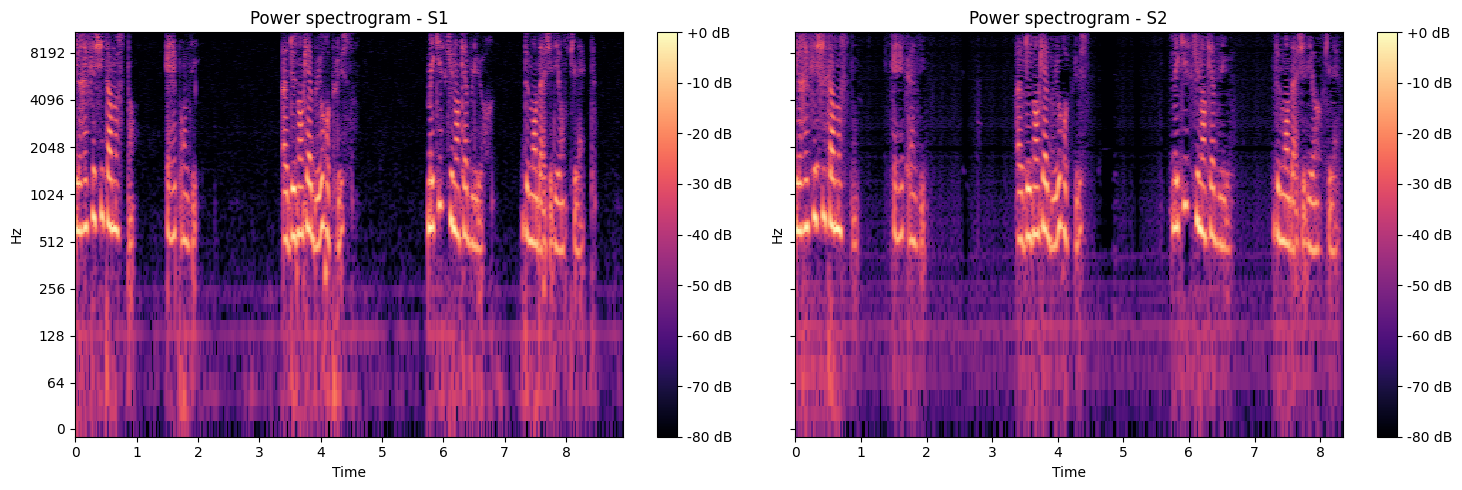

In [274]:
i = 8
audio, sr = librosa.load(f'clean/test/Jules_Verne_-_L_ile_mysterieuse_Partie1_Chap07_{i}_.wav', sr =None)
print_plot_play(audio, sr, text='audio non bruité')
audio1, sr1 = librosa.load(f'noisy/test/Jules_Verne_-_L_ile_mysterieuse_Partie1_Chap07_{i}_.wav', sr=None)
print_plot_play(audio1, sr1, text='audio bruité')
snr_value = calculate_snr(audio, audio1)
print(f"SNR entre les signaux propres et bruités : {snr_value:.2f} dB")

audio2, sr2 = librosa.load(f'predict/test_lstm/Jules_Verne_-_L_ile_mysterieuse_Partie1_Chap07_{i}_.wav', sr=None)
print_plot_play(audio2, sr2, text='audio bruité')
snr_value2 = calculate_snr(audio, audio2)
print(f"SNR entre les signaux propres et prédit : {snr_value2:.2f} dB")

spectrogramme_display(audio, audio1)
spectrogramme_display(audio, audio2)